# LSTM Baseline Model Testing

## 0 Imports & Constants

In [25]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [26]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
import itertools

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from utils.utils import load_time_series, add_lagged_data, scale_data, train_test_split_to_tensor, inverse_scale_data
from TimeSeriesDataset import TimeSeriesDataset

from baseline_model.LSTM import LSTM, train_model

In [27]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [28]:
DATA_FOLDER = Path("../data")
MULTIVARIATE_DATA_FOLDER = DATA_FOLDER / "multivariate"
UNIVARIATE_DATA_FOLDER = DATA_FOLDER / "univariate"
BENCHMARK = False

### Hyperparameters

In [29]:
LAG = 14
LEARNING_RATE = 0.001
BATCH_SIZE = 32
HIDDEN_SIZE = 12
NUM_LAYERS = 1

NUM_EPOCHS = 1000

### Features

In [30]:
FEATURES = ['Close', 'Volume']
NUM_FEATURES_PER_TIME_STEP = len(FEATURES)
FEATURES_INCL_DATE = FEATURES + ['Date']

## 2 Data

### Data Loading

In [31]:
# Load data from csv
# -> convert Date column to datetime
data = load_time_series(f'{UNIVARIATE_DATA_FOLDER}/NVDA_open_high_low_close_adjClose_volume_99_24.csv')
data = data[FEATURES_INCL_DATE] # remember to put the target column first
data[10:]

,Close,Volume,Date
10,0.041276,136848000,1999-02-05
11,0.039844,154080000,1999-02-08
12,0.038281,86976000,1999-02-09
13,0.037891,148224000,1999-02-10
14,0.041146,132240000,1999-02-11
...,...,...,...
6386,121.790001,314162700,2024-06-10
6387,120.910004,222551200,2024-06-11
6388,125.199997,299595000,2024-06-12
6389,129.610001,260704500,2024-06-13


### Data Preprocessing

In [32]:
shifted_np_array = add_lagged_data(data, LAG, FEATURES)

Adding lagged data for columns: ['Close', 'Volume']
Shape of the numpy array wit lagged data: (6377, 15, 2)


In [33]:
shifted_np_array, scaler_close = scale_data(shifted_np_array)
shifted_np_array

array([[[5.33274113e-05, 1.22199380e-02],
        [2.91412246e-05, 1.39552214e-02],
        [3.32838305e-05, 7.30590752e-03],
        ...,
        [6.69216916e-05, 3.51225511e-02],
        [9.83429019e-05, 5.32830987e-02],
        [6.48377632e-05, 2.92580231e-01]],

       [[7.11057432e-05, 9.77595043e-03],
        [5.42616394e-05, 1.22199380e-02],
        [3.01679654e-05, 1.39552214e-02],
        ...,
        [6.57891974e-05, 2.43929765e-02],
        [6.74647412e-05, 3.51225511e-02],
        [1.05209864e-04, 5.32830987e-02]],

       [[7.30777425e-05, 2.07712891e-02],
        [7.23514250e-05, 9.77595043e-03],
        [5.61734547e-05, 1.22199380e-02],
        ...,
        [6.46479918e-05, 2.25638941e-02],
        [6.63230573e-05, 2.43929765e-02],
        [7.21755828e-05, 3.51225511e-02]],

       ...,

       [[9.49334727e-01, 3.03886279e-02],
        [9.32857901e-01, 2.20244625e-02],
        [9.72756186e-01, 3.19701523e-02],
        ...,
        [9.27206806e-01, 4.44909532e-02],
     

In [34]:
X_train, y_train, X_test, y_test = train_test_split_to_tensor(shifted_np_array)


Shape of X_train: torch.Size([6058, 14, 2]) 
 Shape of y_train: torch.Size([6058, 1]) 
 Shape of X_test: torch.Size([319, 14, 2]) 
 Shape of y_test: torch.Size([319, 1])


In [35]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 14, 2]) torch.Size([32, 1])


## 3 Train Test Loop

In [38]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=NUM_FEATURES_PER_TIME_STEP,
    hidden_size=HIDDEN_SIZE,
    num_stacked_layers=NUM_LAYERS
).to(device)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001)
criterion = nn.MSELoss()

In [40]:
if not BENCHMARK:
    best_validation_loss, model = train_model(model=model,
                        train_loader=train_loader,
                        test_loader=test_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=device)

Epoch: 1
Validation Loss: 0.07996290600858628
**************************************************
Epoch: 2
Validation Loss: 0.05179031535371905
**************************************************
Epoch: 3
Validation Loss: 0.045630896452348677
**************************************************
Epoch: 4
Validation Loss: 0.04214131177541276
**************************************************
Epoch: 5
Validation Loss: 0.04071392084224499
**************************************************
Epoch: 6
Validation Loss: 0.03887910898338305
**************************************************
Epoch: 7
Validation Loss: 0.0383620784865343
**************************************************
Epoch: 8
Validation Loss: 0.037829435261664913
**************************************************
Epoch: 9
Validation Loss: 0.03441394962719642
**************************************************
Epoch: 10
Validation Loss: 0.0332088028160797
**************************************************
Epoch: 11
Validation Loss: 0.

## 4 Plot Predictions

### Inverse Transform

In [41]:
X_test.shape

torch.Size([319, 14, 2])

In [42]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [43]:
test_pred = inverse_scale_data(test_pred, scaler_close, LAG)
train_pred = inverse_scale_data(train_pred, scaler_close, LAG)
y_test = inverse_scale_data(y_test, scaler_close, LAG)
y_train = inverse_scale_data(y_train, scaler_close, LAG)

Shape of the inverse scaled numpy array: (319,)
Shape of the inverse scaled numpy array: (6058,)
Shape of the inverse scaled numpy array: (319,)
Shape of the inverse scaled numpy array: (6058,)


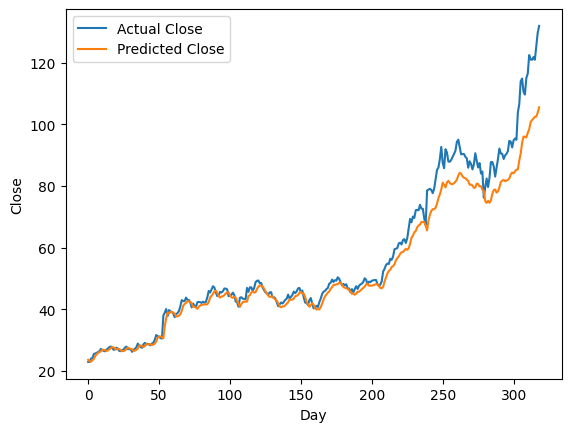

In [44]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


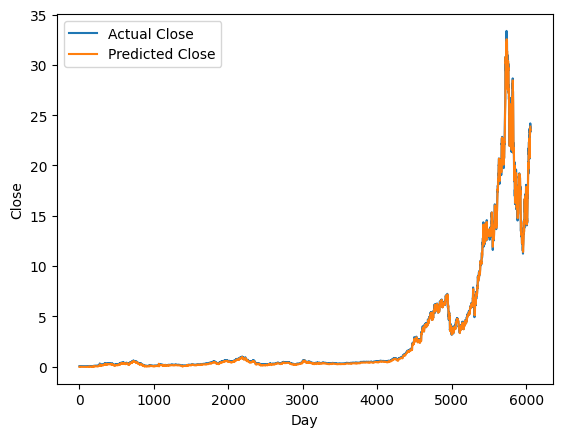

In [45]:
# plot train data
plt.plot(y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()
